In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="2";  
 
# Do other imports now...
import tensorflow as tf

In [ ]:
# train assessment and plan finder model

In [2]:
# import libraries
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.distributed import Client
import seaborn as sns
import pickle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

datafolder = '/data/clin_notes_outcomes/prissmm_notes/'

In [3]:
# load tokenizer if already trained
with open('/homes10/klkehl/prissmm_notes_v2/notes_tokenizer_ap_find.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    

In [4]:
# read datasets
training = pd.read_parquet('/data/clin_notes_outcomes/prissmm_notes/training_notes_find_ap.parquet')
validation = pd.read_parquet('/data/clin_notes_outcomes/prissmm_notes/validation_notes_find_ap.parquet')
test = pd.read_parquet('/data/clin_notes_outcomes/prissmm_notes/test_notes_find_ap.parquet')

In [5]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1083879 entries, 0 to 1083878
Data columns (total 9 columns):
dfci_mrn         1083879 non-null int64
date             1083879 non-null datetime64[ns]
source           1083879 non-null object
department       1031627 non-null object
provider_name    1083879 non-null object
report_type      1083879 non-null object
pre_ap           1083879 non-null object
ap               1083879 non-null object
Unnamed: 0       1083879 non-null int64
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 82.7+ MB


In [6]:
# read in the manually labeled note dataset we will use later; exclude patients from assessment/plan finder model training if they were in the labeled dataset

labels = pd.read_csv(datafolder + 'redcap_2g_medonc_2-1-19.csv')[['dfci_mrn','onc_visit_dt2','md_ca2','ca_status_md2']].rename(columns={'onc_visit_dt2':'encounter_date'})
training = training[~training.dfci_mrn.isin(labels.dfci_mrn)]
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1049966 entries, 0 to 1083878
Data columns (total 9 columns):
dfci_mrn         1049966 non-null int64
date             1049966 non-null datetime64[ns]
source           1049966 non-null object
department       999111 non-null object
provider_name    1049966 non-null object
report_type      1049966 non-null object
pre_ap           1049966 non-null object
ap               1049966 non-null object
Unnamed: 0       1049966 non-null int64
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 80.1+ MB


In [8]:
# table 1 stuff
temp_train = training[['dfci_mrn', 'date']]
temp_valid = validation[['dfci_mrn', 'date']]
temp_test = test[['dfci_mrn','date']]

table1_find_ap_notes = pd.concat([temp_train, temp_valid, temp_test], axis=0)


temp_folder = '/data/clin_notes_outcomes/clin_trajectory_v3/'
registration = pd.read_csv(temp_folder + 'REQ_82268_PT_INFO_STATUS_REGISTRATION.csv', sep='|', encoding='ISO-8859-1', low_memory=False)

demographics = pd.read_csv(temp_folder + 'REQ_82268_DEMOGRAPHICS_REGISTRATION.csv', sep='|', encoding='ISO-8859-1', low_memory=False)[['patient_id','marital_status_nm','idm_race_nm']]
specimens = pd.read_csv(temp_folder + 'REQ_82268_GENOMIC_SPECIMEN.csv', sep='|', encoding='ISO-8859-1', low_memory=False)[['patient_id', 'test_order_dt', 'primary_cancer_diagnosis']]
specimens.test_order_dt = pd.to_datetime(specimens.test_order_dt)

registration = registration[~registration.dfci_mrn.isnull()]
registration = registration[~registration.patient_id.isnull()]
#registration = registration.query("~dfci_mrn.isnull() & (~patient_id.isnull())")

registration.patient_id = pd.to_numeric(registration.patient_id)
registration.dfci_mrn = pd.to_numeric(registration.dfci_mrn)
registration = registration.groupby('dfci_mrn').first().reset_index()
registration.dfci_mrn = pd.to_numeric(registration.dfci_mrn)
registration.hybrid_death_dt = pd.to_datetime(registration.hybrid_death_dt)
registration.birth_dt = pd.to_datetime(registration.birth_dt)

registration = pd.merge(registration, demographics, how='inner', on='patient_id')
registration = pd.merge(registration, specimens, how='inner', on='patient_id')
registration['age_at_seq'] = (registration.test_order_dt - registration.birth_dt)/np.timedelta64(1,'Y')
registration['age_at_seq'] = pd.cut(registration.age_at_seq, [0,40, 50, 60, 70, 80, 120])
registration['idm_race_nm'] = np.where(registration['idm_race_nm'].str.contains('other|unknown|/', case=False), 'Other/unknown', registration['idm_race_nm'])
registration['marital_status_nm'] = np.where(registration['marital_status_nm'].str.contains('married', case=False), 'Married', 'Unmarried/unknown')

registration['primary_cancer_diagnosis'] = np.where(registration['primary_cancer_diagnosis'].str.contains('lung', case=False), 'Lung cancer', registration['primary_cancer_diagnosis'])
registration['primary_cancer_diagnosis'] = np.where(registration['primary_cancer_diagnosis'].str.contains('panc', case=False), 'Pancreatic cancer', registration['primary_cancer_diagnosis'])
registration['primary_cancer_diagnosis'] = np.where(registration['primary_cancer_diagnosis'].str.contains('breast', case=False), 'Breast cancer', registration['primary_cancer_diagnosis'])
registration['primary_cancer_diagnosis'] = np.where(registration['primary_cancer_diagnosis'].str.contains('urothelial|bladder', case=False), 'Urothelial cancer', registration['primary_cancer_diagnosis'])
registration['primary_cancer_diagnosis'] = np.where(registration['primary_cancer_diagnosis'].str.contains('prostate', case=False), 'Prostate cancer', registration['primary_cancer_diagnosis'])
registration['primary_cancer_diagnosis'] = np.where(registration['primary_cancer_diagnosis'].str.contains('colo|rect', case=False), 'Colorectal cancer', registration['primary_cancer_diagnosis'])

registration['primary_cancer_diagnosis'] = np.where(~registration['primary_cancer_diagnosis'].str.contains('lung|pancreatic|breast|urothelial|bladder|prostate|colo|rect', case=False), 'Other/unknown', registration['primary_cancer_diagnosis'])


# take the first entry for patients who had multiple genomic specimens collected
registration = registration.sort_values(by=['dfci_mrn','test_order_dt'])
registration = registration.groupby(['dfci_mrn']).first().reset_index()

registration = registration[['dfci_mrn','hybrid_death_ind', 'hybrid_death_dt', 'patient_id', 'primary_cancer_diagnosis', 'age_at_seq','marital_status_nm','idm_race_nm', 'gender_nm']]



treatments = pd.read_csv(temp_folder+'REQ_82268_TREATMENT_PLAN.csv', sep='|', encoding='ISO-8859-1', low_memory=False)
pall_rx = treatments[treatments['tplan_goal'] == 'PALLIATIVE'][['patient_id', 'tplan_start_dt']]
pall_rx['pall_start_dt'] = pd.to_datetime(pall_rx.tplan_start_dt)
pall_rx = pd.merge(registration, pall_rx, on='patient_id', how='inner')
pall_rx = pall_rx.drop(['patient_id', 'tplan_start_dt'], axis=1)
pall_rx = pall_rx.sort_values(by=['dfci_mrn'])
pall_rx = pall_rx.groupby(['dfci_mrn']).first().reset_index()


registration['split'] = np.where(registration.dfci_mrn.isin(temp_train.dfci_mrn), 'train', 'none')
registration['split'] = np.where(registration.dfci_mrn.isin(temp_valid.dfci_mrn), 'valid', registration.split)
registration['split'] = np.where(registration.dfci_mrn.isin(temp_test.dfci_mrn), 'test', registration.split)

registration.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29293 entries, 0 to 29292
Data columns (total 10 columns):
dfci_mrn                    29293 non-null float64
hybrid_death_ind            29293 non-null object
hybrid_death_dt             9170 non-null datetime64[ns]
patient_id                  29293 non-null int64
primary_cancer_diagnosis    29293 non-null object
age_at_seq                  29293 non-null category
marital_status_nm           29293 non-null object
idm_race_nm                 29293 non-null object
gender_nm                   29293 non-null object
split                       29293 non-null object
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [9]:
# make table 1 for notes

table1_notes = pd.merge(table1_find_ap_notes, registration, on='dfci_mrn')
print('')

print(pd.crosstab(table1_notes.age_at_seq, table1_notes.split, margins=True), '\n\n', pd.crosstab(table1_notes.age_at_seq, table1_notes.split, normalize='columns', margins=True))
print('\n\n')
print(pd.crosstab(table1_notes.idm_race_nm, table1_notes.split, margins=True), '\n\n', pd.crosstab(table1_notes.idm_race_nm, table1_notes.split, normalize='columns', margins=True))

print('\n\n')
print(pd.crosstab(table1_notes.marital_status_nm, table1_notes.split, margins=True), '\n\n', pd.crosstab(table1_notes.marital_status_nm, table1_notes.split, normalize='columns', margins=True))

print('\n\n')
print(pd.crosstab(table1_notes.gender_nm, table1_notes.split, margins=True), '\n\n', pd.crosstab(table1_notes.gender_nm, table1_notes.split, normalize='columns', margins=True))

print('\n\n')
print(pd.crosstab(table1_notes.primary_cancer_diagnosis, table1_notes.split, margins=True), '\n\n', pd.crosstab(table1_notes.primary_cancer_diagnosis, table1_notes.split, normalize='columns', margins=True))



split         test   train   valid      All
age_at_seq                                 
(0, 40]      11715   88295   12598   112608
(40, 50]     11998  109756   11995   133749
(50, 60]     29573  228938   26050   284561
(60, 70]     36972  286819   37293   361084
(70, 80]     24352  173501   25774   223627
(80, 120]     7377   52763    7614    67754
All         121987  940072  121324  1183383 

 split           test     train     valid       All
age_at_seq                                        
(0, 40]     0.096035  0.093924  0.103838  0.095158
(40, 50]    0.098355  0.116753  0.098867  0.113023
(50, 60]    0.242427  0.243532  0.214714  0.240464
(60, 70]    0.303081  0.305103  0.307384  0.305129
(70, 80]    0.199628  0.184561  0.212439  0.188973
(80, 120]   0.060474  0.056127  0.062758  0.057254



split                                test   train   valid      All
idm_race_nm                                                       
American Indian or Alaskan Native      66     719     1

In [10]:
# make table 1 for ap finder patients

table1_pts = pd.merge(registration, table1_find_ap_notes, on='dfci_mrn').groupby(['dfci_mrn']).first().reset_index()

print('')

print(pd.crosstab(table1_pts.age_at_seq, table1_pts.split, margins=True), '\n\n', pd.crosstab(table1_pts.age_at_seq, table1_pts.split, normalize='columns', margins=True))
print('\n\n')
print(pd.crosstab(table1_pts.idm_race_nm, table1_pts.split, margins=True), '\n\n', pd.crosstab(table1_pts.idm_race_nm, table1_pts.split, normalize='columns', margins=True))

print('\n\n')
print(pd.crosstab(table1_pts.marital_status_nm, table1_pts.split, margins=True), '\n\n', pd.crosstab(table1_pts.marital_status_nm, table1_pts.split, normalize='columns', margins=True))

print('\n\n')
print(pd.crosstab(table1_pts.gender_nm, table1_pts.split, margins=True), '\n\n', pd.crosstab(table1_pts.gender_nm, table1_pts.split, normalize='columns', margins=True))

print('\n\n')
print(pd.crosstab(table1_pts.primary_cancer_diagnosis, table1_pts.split, margins=True), '\n\n', pd.crosstab(table1_pts.primary_cancer_diagnosis, table1_pts.split, normalize='columns', margins=True))




split       test  train  valid    All
age_at_seq                           
(0, 40]      292   2357    277   2926
(40, 50]     290   2256    319   2865
(50, 60]     623   4820    628   6071
(60, 70]     844   6316    800   7960
(70, 80]     579   4251    572   5402
(80, 120]    187   1339    172   1698
All         2815  21339   2768  26922 

 split           test     train     valid       All
age_at_seq                                        
(0, 40]     0.103730  0.110455  0.100072  0.108684
(40, 50]    0.103020  0.105722  0.115246  0.106419
(50, 60]    0.221314  0.225878  0.226879  0.225503
(60, 70]    0.299822  0.295984  0.289017  0.295669
(70, 80]    0.205684  0.199213  0.206647  0.200654
(80, 120]   0.066430  0.062749  0.062139  0.063071



split                              test  train  valid    All
idm_race_nm                                                 
American Indian or Alaskan Native     3     24      2     29
Asian                                64    601     77    742

In [11]:
# max note length = 2000 words
max_note_length=2000

In [12]:
# taken out for evaluation but should be uncommented for training
# train_pre_ap = [np.array(x) for x in tokenizer.texts_to_sequences(training.pre_ap)]
# train_y_pre_ap = [np.zeros_like(x) for x in train_pre_ap]
# train_ap = [np.array(x) for x in tokenizer.texts_to_sequences(training.ap)]
# train_y_ap = [np.ones_like(x) for x in train_ap]
# train_x = sequence.pad_sequences([np.concatenate([a,b]) for a,b in zip(train_pre_ap, train_ap)], maxlen=max_note_length)
# train_y = sequence.pad_sequences([np.concatenate([a,b]) for a,b in zip(train_y_pre_ap, train_y_ap)], maxlen=max_note_length)

In [13]:
valid_pre_ap = [np.array(x) for x in tokenizer.texts_to_sequences(validation.pre_ap)]
valid_y_pre_ap = [np.zeros_like(x) for x in valid_pre_ap]
valid_ap = [np.array(x) for x in tokenizer.texts_to_sequences(validation.ap)]
valid_y_ap = [np.ones_like(x) for x in valid_ap]
valid_x = sequence.pad_sequences([np.concatenate([a,b]) for a,b in zip(valid_pre_ap, valid_ap)], max_note_length)
valid_y = sequence.pad_sequences([np.concatenate([a,b]) for a,b in zip(valid_y_pre_ap, valid_y_ap)], max_note_length)

In [14]:
test_pre_ap = [np.array(x) for x in tokenizer.texts_to_sequences(test.pre_ap)]
test_y_pre_ap = [np.zeros_like(x) for x in test_pre_ap]
test_ap = [np.array(x) for x in tokenizer.texts_to_sequences(test.ap)]
test_y_ap = [np.ones_like(x) for x in test_ap]
test_x = sequence.pad_sequences([np.concatenate([a,b]) for a,b in zip(test_pre_ap, test_ap)], max_note_length)
test_y = sequence.pad_sequences([np.concatenate([a,b]) for a,b in zip(test_y_pre_ap, test_y_ap)], max_note_length)

In [16]:
# ML imports
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, concatenate
from tensorflow.keras.layers import Embedding
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, LSTM, TimeDistributed, GRU, Bidirectional, Layer
from tensorflow.keras import backend as K


In [19]:
# set up deep learning model



vocab_size = 10000
embedding_dims = 256
filters = 250
kernel_size = 4
lstm_dims = 129
epochs = 2
hidden_dims = 128
max_note_length=2000
batch_size = 32
from tensorflow.keras.layers import Reshape

# make model

model = Sequential()
model.add(Input(shape=(max_note_length,), dtype='float32'))
model.add(Embedding(vocab_size, embedding_dims, input_length=max_note_length, mask_zero=False))
model.add(Bidirectional(LSTM(lstm_dims, return_sequences=True)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))


model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 256)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, 2000, 258)         398352    
_________________________________________________________________
time_distributed (TimeDistri (None, 2000, 1)           259       
Total params: 2,958,611
Trainable params: 2,958,611
Non-trainable params: 0
_________________________________________________________________


In [15]:
# train model. This will be slow on CPU instance. 

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='ap_model.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-2,
        patience=2,
        verbose=1
    )
]

model.fit(train_x, train_y,
         validation_data=(valid_x, valid_y),
         epochs=2,
         batch_size = 32, use_multiprocessing=True, callbacks=callbacks)

Train on 1049966 samples, validate on 134459 samples
Epoch 1/2
1049952/1049966 [============================>.] - ETA: 0s - loss: 0.0631
Epoch 00001: val_loss improved from inf to 0.06155, saving model to ap_model.h5
1049966/1049966 [==============================] - 10053s 10ms/sample - loss: 0.0631 - val_loss: 0.0615
Epoch 2/2
1049952/1049966 [============================>.] - ETA: 0s - loss: 0.0333
Epoch 00002: val_loss did not improve from 0.06155
1049966/1049966 [==============================] - 10018s 10ms/sample - loss: 0.0333 - val_loss: 0.0619


In [20]:
# save model and test loading
model.load_weights('ap_model.h5')

In [21]:
# apply model to validation and then test set data to evaluate it
valid_predictions = model.predict(valid_x)
test_predictions = model.predict(test_x)




In [22]:
valid_predictions = np.squeeze(valid_predictions, 2)
test_predictions = np.squeeze(test_predictions, 2)

In [23]:
print(valid_predictions.shape, valid_y.shape)
print(test_predictions.shape, test_y.shape)

(134459, 2000) (134459, 2000)
(135879, 2000) (135879, 2000)


In [24]:
%matplotlib inline

In [25]:
# helper functions to plot model metrics
# based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    import numpy as np


    from sklearn.metrics import confusion_matrix
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(False)
    plt.show()

In [26]:
# evaluate model auc

# graphing code based in part on https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python/47562197 and https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html


def eval_model(predicted, actual):
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import auc
    from sklearn.metrics import roc_curve

    print("AUC " + str(roc_auc_score(actual, predicted)))

    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(actual, predicted)
    roc_auc = auc(fpr, tpr)

    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(actual, predicted)

    print('Average precision score: {0:0.2f}'.format(
        average_precision))


    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic: ' )
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()



    import matplotlib.pyplot as plt
    #from sklearn.utils.fixes import signature

    precision, recall, thresholds = precision_recall_curve(actual, predicted)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
#     step_kwargs = ({'step': 'post'}
#                  if 'step' in signature(plt.fill_between).parameters
#                  else {})
    
    outcome_counts = np.unique(actual, return_counts=True)[1]
    prob_outcome = outcome_counts[1] / (outcome_counts[0] + outcome_counts[1])
    print('Outcome probability:')
    print(prob_outcome)
    
    plt.plot(recall, precision, color='b')
    plt.plot([0,1],[prob_outcome,prob_outcome], 'r--')
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')

    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision (PPV)')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
            average_precision))
    plt.show()


    # best F1
    F1 = 2*((precision*recall)/(precision+recall))
    print("Best F1 ")
    print(max(F1))
    
    # threshold for best F1
    bestF1_thresh = thresholds[np.argmax(F1)]
    print("Threshold for best F1:")
    print(bestF1_thresh)
    pred_outcome_best_f1_thresh = np.where(predicted >= bestF1_thresh,1,0)
    print(np.unique(pred_outcome_best_f1_thresh, return_counts=True))
    pred_outcome_05_thresh = np.where(predicted >= 0.5,1,0)
    
    # # predictions
    
    # # confusion matrix
    print("Confusion matrix at best F1 thresh:")
    from sklearn.metrics import confusion_matrix
    cnf_matrix = confusion_matrix(actual, pred_outcome_best_f1_thresh)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                        title='Confusion matrix, without normalization')
    print("Metrics at best F1 thresh (specificity is recall for negative class):")
    from sklearn.metrics import classification_report
    print(classification_report(actual, pred_outcome_best_f1_thresh, target_names=['No','Yes']))


    print("Confusion matrix at 0.5 thresh:")
    from sklearn.metrics import confusion_matrix
    cnf_matrix = confusion_matrix(actual, pred_outcome_05_thresh)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                        title='Confusion matrix, without normalization')
    print("Metrics at 0.5 thresh thresh (specificity is recall for negative class):")
    print(classification_report(actual, pred_outcome_05_thresh, target_names=['No','Yes']))



    # Plot normalized confusion matrix
    #   plt.figure()
    #   plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
    #                         title='Normalized confusion matrix')


    # # plot threshold vs ppv curve
    plt.plot(thresholds, precision[0:len(precision)-1], color='b')
    # plt.step(recall, precision, color='b', alpha=0.2,
    #          where='post')
    # plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Threshold probability')
    plt.ylabel('Precision (PPV)')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title('Threshold vs precision')
    plt.show()

    # histogram
    plt.hist(predicted)
    plt.title("Histogram")
    plt.xlabel("Predicted probability" )
    plt.ylabel("Frequency")
    plt.show()

Evaluate AP finder model on validation and test sets

AUC 0.9908467200379328
Average precision score: 0.94


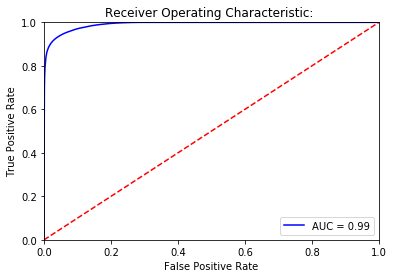

Outcome probability:
0.09070890382942012


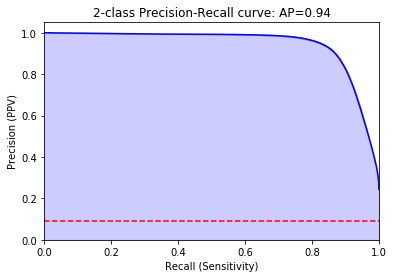

Best F1 
0.8872268584408542
Threshold for best F1:
0.46623743
(array([0, 1]), array([246420553,  22497447]))
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[242828642   1696101]
 [  3591911  20801346]]


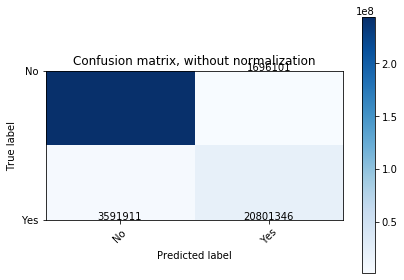

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.99      0.99      0.99 244524743
         Yes       0.92      0.85      0.89  24393257

    accuracy                           0.98 268918000
   macro avg       0.96      0.92      0.94 268918000
weighted avg       0.98      0.98      0.98 268918000

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[242968598   1556145]
 [  3709326  20683931]]


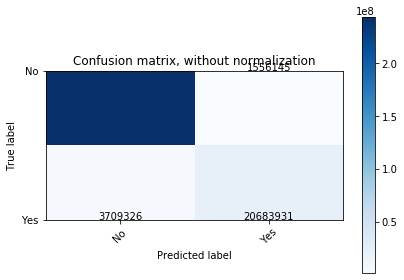

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.98      0.99      0.99 244524743
         Yes       0.93      0.85      0.89  24393257

    accuracy                           0.98 268918000
   macro avg       0.96      0.92      0.94 268918000
weighted avg       0.98      0.98      0.98 268918000



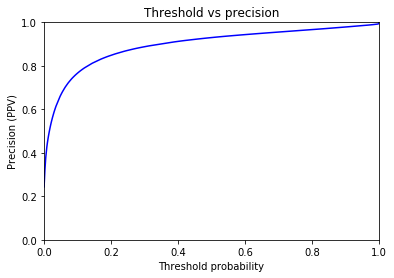

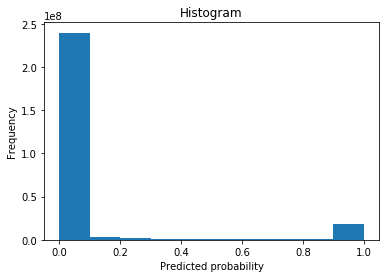

In [27]:
eval_model(valid_predictions.flatten(), valid_y.flatten())

AUC 0.9917714565531253
Average precision score: 0.95


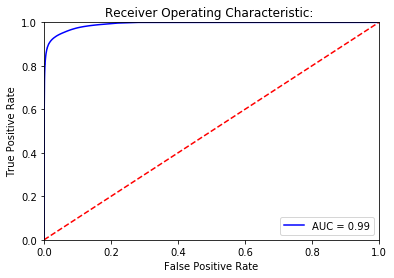

Outcome probability:
0.09450100824998713


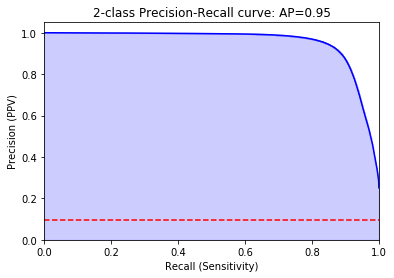

Best F1 
0.8965354679101663
Threshold for best F1:
0.467122
(array([0, 1]), array([247735377,  24022623]))
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[244334684   1741911]
 [  3400693  22280712]]


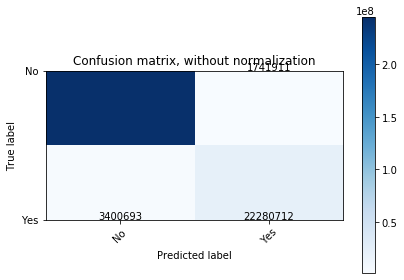

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.99      0.99      0.99 246076595
         Yes       0.93      0.87      0.90  25681405

    accuracy                           0.98 271758000
   macro avg       0.96      0.93      0.94 271758000
weighted avg       0.98      0.98      0.98 271758000

Confusion matrix at 0.5 thresh:


In [ ]:
eval_model(test_predictions.flatten(), test_y.flatten())